# Steam Games Analysis

## Load Data from .CSV source

Data was collected from: [Kaggle](https://www.kaggle.com/connorwynkoop/steam-monthly-player-data)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load data
games_df = pd.read_csv("AllSteamData.csv")
display(games_df.sample(5))

,Name,Month,Avg. Players,Gain,% Gain,Peak Players
125025,Virtua Tennis 4,Dec-20,1.32,-0.04,-3.06%,10
418960,Bard's Gold,Mar-20,1.08,0.09,9.43%,12
191181,Armada 2526 Gold Edition,Oct-20,2.74,0.7,34.51%,10
245572,Castle In The Darkness,Oct-16,3.49,-0.13,-3.71%,11
594064,Rescue your chickens,Jan-17,6.12,6.02,5831.84%,388


**Name**: It's the game name.

**Month**: Month and Year the data corresponds to.

**Avg. Players**: Average Players per month.

**Gain**: Change from previous month.

**% Gain**: Percent change from previous month.

**Peak Players**: Peak players for that month.

### Data cleaning

Let's check for missing values on our dataset.

In [2]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878175 entries, 0 to 878174
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Name          878175 non-null  object 
 1   Month         878175 non-null  object 
 2   Avg. Players  878175 non-null  float64
 3   Gain          867341 non-null  object 
 4   % Gain        867341 non-null  object 
 5   Peak Players  878175 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 40.2+ MB


As we can see, there are some missing values in 3 of our columns, but also we have some erroneous data in our columns.

In [3]:
for c in games_df.columns:
    print(f"=== For {c} ===")
    print(games_df[c].value_counts())

=== For Name ===
Sid Meier's Civilization IV              224
S.T.A.L.K.E.R.: Shadow of Chernobyl      224
Grand Theft Auto: San Andreas            224
Grand Theft Auto: Vice City              224
Sid Meier's Civilization IV: Warlords    224
                                        ... 
Dark Abyss                                 1
Straight Battler VI                        1
Stoneshard - Supporter Pack                1
The Sperminator: Rescuing Tzar Vlad        1
Outbreak Island Demo                       1
Name: Name, Length: 38164, dtype: int64
=== For Month ===
Last 30 Days    38293
Aug-19          15865
Apr-19          15633
Jun-19          15044
Jul-19          14681
                ...  
Nov-12           1872
Oct-12           1808
Sep-12           1734
Aug-12           1679
Jul-12           1620
Name: Month, Length: 112, dtype: int64
=== For Avg. Players ===
0.00      35454
0.01      20002
0.02      12067
0.03      11197
0.04       9774
          ...  
576.57        1
263.03      

This dataset has some erroneous rows; for example, in the Month column, there are 38293 rows with the "Last 30 Days" value which we can't analyze, so that rows will be dropped. Same for the Gain column, which has "-" values that mean nothing, as this value doesn't represent a large amount of data, it will be dropped.

In [4]:
to_analyze = games_df[(games_df["Gain"] != '-') & (games_df["% Gain"] != '-') & (games_df["Month"] != "Last 30 Days")]

In [5]:
# Transform data types
to_analyze.loc[:, "Gain"] = pd.to_numeric(to_analyze["Gain"])
to_analyze.loc[:, "% Gain"] = to_analyze["% Gain"].apply(lambda x: x.replace('%', ''))
to_analyze.loc[:, "% Gain"] = to_analyze["% Gain"].apply(lambda x: 0 if 'NaN' in x else x) # Fill NaN with 0
perc_gain_median = to_analyze["% Gain"].median()
to_analyze.loc[:, "% Gain"] = to_analyze["% Gain"].apply(lambda x: perc_gain_median if x == 0 else x)
to_analyze.loc[:, "% Gain"] = pd.to_numeric(to_analyze["% Gain"])
to_analyze.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812423 entries, 1 to 877588
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Name          812423 non-null  object 
 1   Month         812423 non-null  object 
 2   Avg. Players  812423 non-null  float64
 3   Gain          812423 non-null  float64
 4   % Gain        812423 non-null  float64
 5   Peak Players  812423 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 43.4+ MB


## Exploratory Data Analysis

To start with EDA, let's make some other changes to analyze better changing the DataType of Month and separating it.

In [6]:
# Split Month column in Only Month and Day
def split_month(dataframe, column: str, data: str):
    """
    To get only month or only day from a dataframe column
    Parameters:
    -----------
    column: str
        Column name
    data: str
        If you want the month or the day
    Returns:
    --------
    new_column: pandas.DataFrame.columns
        The new column with the extracted data
    """
    new_column = dataframe[column].apply(lambda x: x.split('-')[0] if data == "month" else x.split('-')[1])
    return new_column

In [7]:
# Getting months and day number in different columns
to_analyze.loc[:, "Only Month"] = split_month(to_analyze, "Month", "month").str.capitalize()
to_analyze.loc[:, "Only Day"] = split_month(to_analyze, "Month", "day")
to_analyze.sample(5)

,Name,Month,Avg. Players,Gain,% Gain,Peak Players,Only Month,Only Day
329776,Darkstone,Apr-17,1.90,-0.24,-11.13,8,Apr,17
429622,The chronicles of Emerland. Solitaire.,Mar-19,2.52,-1.10,-30.45,10,Mar,19
525904,You're Next,Feb-19,0.01,0.00,12.23,1,Feb,19
64267,Imperium Romanum: Gold Edition Demo,Sep-16,0.13,-0.12,-47.14,2,Sep,16
599859,Equilibrium Of Divinity,Nov-17,0.82,-0.74,-47.22,4,Nov,17


In [8]:
to_analyze["Month Number"] = pd.to_datetime(to_analyze["Only Month"], format="%b", errors="coerce").dt.month
to_analyze.sample(5)

,Name,Month,Avg. Players,Gain,% Gain,Peak Players,Only Month,Only Day,Month Number
346137,Axiom Verge,Oct-17,29.93,6.34,26.85,102,Oct,17,10
345472,Why So Evil,Apr-20,28.48,-53.35,-65.20,514,Apr,20,4
206713,Bionic Dues,Nov-15,28.26,-122.91,-81.30,70,Nov,15,11
416511,Animated Puzzles,Dec-18,0.97,-0.14,-12.45,5,Dec,18,12
27859,Conflict: Denied Ops Demo,May-18,0.08,-0.02,-20.76,1,May,18,5


In [9]:
def bar_and_line_plot(column1, column2, dataframe = []):
    """
    Function to create a bar plot with a line on the top of each bar.
    Parameters:
    -----------
    dataframe: pandas.DataFrame
        DataFrame where we will extract data
    column1: str
        Column 1 is the column that will be in the x axis.
    column2: str
        Column 2 is the column that will be in the y axis.
    Returns:
    -------
    fig:
        A matplotlib figure to show the graph
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=column1, y=column2, data=dataframe, marker='o', sort=False, ax=ax1)
    sns.barplot(data=dataframe, x=column1, y=column2, alpha=0.5, ax=ax1)
    plt.title("General Avg. Players by Month")
    plt.xlabel("Month")
    plt.ylabel("Avg. Players")
    return fig

### General Avg. Players by Month



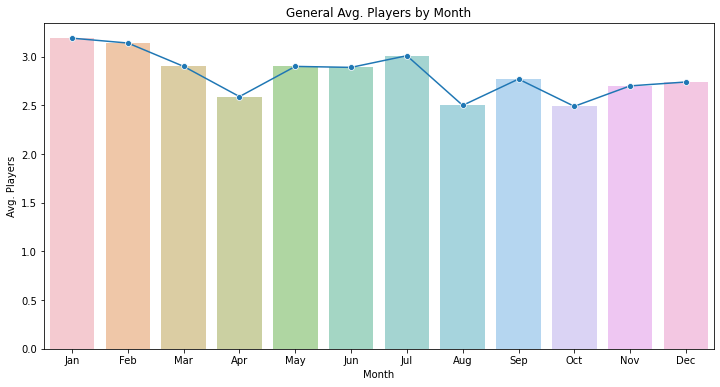

In [10]:
# Getting general avg. data for each month for every game listed
months = to_analyze["Only Month"].value_counts().keys().to_list()
month_n = []
general_avg_players = []
for m in months:
    current_avg = to_analyze[to_analyze["Only Month"] == m]["Avg. Players"].median()
    current_month_number = to_analyze[to_analyze["Only Month"] == m]["Month Number"].value_counts().keys().to_list()[0]
    month_n.append(current_month_number)
    general_avg_players.append(current_avg)
# Save in DataFrame
months_and_average_gen = pd.DataFrame()
months_and_average_gen["Month"] = months
months_and_average_gen["Month n"] = month_n
months_and_average_gen["Gen. Avg."] = general_avg_players
months_and_average_gen.sort_values("Month n", inplace=True)
# Call the graph function
general_graph = bar_and_line_plot("Month", "Gen. Avg.", months_and_average_gen)